# Network model 

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import argrelmin, oaconvolve
from scipy.stats import gennorm
from network_model import (
    MicroMagnet,
    solve_circuit,
    generate_averaging_filter,
)
from tqdm.notebook import tqdm

import matplotlib.cm as cm

In [2]:
mu_B = 5.788e-5

## Loading of the fitting data

In [3]:
# SAMPLE 12
downsweep_file_url = (
    "../bilayers_fittings/fitting_results/MDC004_Sample1_RunID_15_lockin6_M_fit.csv"
)
upsweep_file_url = (
    "../bilayers_fittings/fitting_results/MDC004_Sample1_RunID_16_lockin6_M_fit.csv"
)
down_data = pd.read_csv(downsweep_file_url)
up_data = pd.read_csv(upsweep_file_url)

B_ax = up_data["B"].values
dB = B_ax[1] - B_ax[0]

Delta_up = up_data["Delta"].values
x_N_up = up_data["x_N"].values
h_up = up_data["h"].values

Delta_down = down_data["Delta"].values
x_N_down = down_data["x_N"].values
h_down = down_data["h"].values

h_up[: argrelmin(h_up)[0][1]] *= -1
h_down[: argrelmin(h_down)[0][0]] *= -1

NS_idx_up = np.argwhere(np.diff(Delta_up) != 0)[:, 0][0] + 1
SN_idx_up = np.argwhere(np.diff(Delta_up) != 0)[:, 0][-1]

NS_idx_down = np.argwhere(np.diff(Delta_down) != 0)[:, 0][0] + 1
SN_idx_down = np.argwhere(np.diff(Delta_down) != 0)[:, 0][-1]

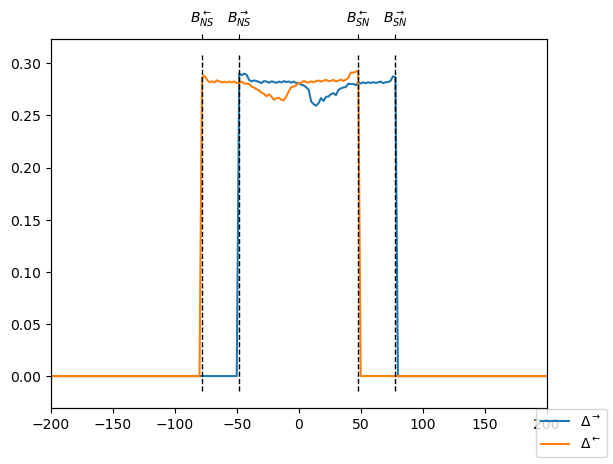

In [4]:
fig, ax1 = plt.subplots()

ax1.plot(B_ax, Delta_up, label=r"$\Delta^\rightarrow$")
ax1.plot(B_ax, Delta_down, label=r"$\Delta^\leftarrow$")

ax1.vlines(
    B_ax[[NS_idx_up, SN_idx_up, NS_idx_down, SN_idx_down]],
    *ax1.get_ylim(),
    "k",
    linestyles="--",
    linewidth=1
)
ax1.set_xlim(B_ax.min(), B_ax.max())

ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(
    [*B_ax[[NS_idx_up, SN_idx_up, NS_idx_down, SN_idx_down]]],
    labels=[
        r"$B_{NS}^\rightarrow$",
        r"$B^\rightarrow_{SN}$",
        r"$B_{NS}^\leftarrow$",
        r"$B^\leftarrow_{SN}$",
    ],
)

fig.legend(loc="lower right")

In [5]:
print("min:")
print(Delta_up[NS_idx_up:SN_idx_up].min() / np.sqrt(2))
print(Delta_down[NS_idx_down:SN_idx_down].min() / np.sqrt(2))

print("max:")
print(Delta_up.max() / np.sqrt(2))
print(Delta_down.max() / np.sqrt(2))

print("means:")
print(Delta_up[NS_idx_up:SN_idx_up].mean() / np.sqrt(2))
print(Delta_down[NS_idx_down:SN_idx_down].mean() / np.sqrt(2))

print("stdev:")
print(Delta_up[NS_idx_up:SN_idx_up].std() / np.sqrt(2))
print(Delta_down[NS_idx_down:SN_idx_down].std() / np.sqrt(2))

min:
0.18339189834764924
0.18710425292096938
max:
0.2051645210807811
0.20720093386585858
means:
0.1972556154376344
0.1978364460709279
stdev:
0.004890742336551517
0.004572470823822239


In [6]:
# Select a critical field
h_c = 0.198

## NIS

In [7]:
Nx = 200  # Number of domains
Ny = 200

border = 50

In [8]:
# g-factor
g = 2

In [9]:
# Disorder in h_s
disorder_beta = 2
disorder_scale = 0
rvs = gennorm.rvs(
    loc=1,
    scale=disorder_scale,
    beta=disorder_beta,
    size=(Nx + 2 * border) * (Ny + 2 * border),
)
rvs = rvs.reshape(Nx + 2 * border, Ny + 2 * border)

In [10]:
def get_NIS(Ny, Nx, B_ax, M_fun, g, h_s, h_c, xi, seed=None):
    """
    Calculate NIS conductance by taking ratio of the Sc domain over normal domains.
    """
    conductance = np.zeros_like(B_ax)

    averaging_filter = generate_averaging_filter(xi)
    mm = MicroMagnet(shape=(Ny + 2 * border, Nx + 2 * border), seed=seed)

    for i, B in enumerate(B_ax):
        mm.set_M(M_fun(B))

        h_eff = (
            oaconvolve(h_s * mm.config, averaging_filter, mode="same")
            + g / 2 * mu_B * B
        )
        domains_sc = 1 * (abs(h_eff) < h_c)

        if border > 0:
            h_eff = h_eff[border:-border, border:-border]
            domains_sc = domains_sc[border:-border, border:-border]

        conductance[i] = 1 - np.sum(domains_sc) / (Ny * Nx)

    return conductance

In [11]:
def M_fun(x, o, s1, s2, C1, C2):
    t1 = (x - o) / s1
    t2 = (x - o) / s2

    return (C1 * np.tanh(t1) + C2 * np.tanh(t2)) / (C1 + C2)

In [12]:
N_samples = 5  # DISORDER AVERAGING


def wrapper(params):
    h_s, xi = params

    h_cc = h_c * np.ones((Nx + 2 * border, Ny + 2 * border))
    h_ss = h_s * np.ones((Nx + 2 * border, Ny + 2 * border))

    M_up = (h_up - g * mu_B / 2 * B_ax) / h_s

    popt_up, pcov_up = curve_fit(
        M_fun,
        B_ax[NS_idx_up:SN_idx_up],
        M_up[NS_idx_up:SN_idx_up],
        bounds=((-np.inf, 0, 0, 0, 0), (+np.inf, np.inf, np.inf, 1, 1)),
        maxfev=4000,
    )

    def M_fun_up(B):
        return M_fun(B, *popt_up)

    M_down = (h_down - g * mu_B / 2 * B_ax) / h_s

    popt_down, pcov_down = curve_fit(
        M_fun,
        B_ax[NS_idx_down:SN_idx_down],
        M_down[NS_idx_down:SN_idx_down],
        bounds=((-np.inf, 0, 0, 0, 0), (+np.inf, np.inf, np.inf, 1, 1)),
        maxfev=4000,
    )

    def M_fun_down(B):
        return M_fun(B, *popt_down)

    res_up = 0
    res_down = 0

    for seed in range(N_samples):
        nis_th_up = get_NIS(Nx, Ny, B_ax, M_fun_up, g, h_s * rvs, h_c, xi, seed=seed)
        nis_th_down = get_NIS(
            Nx, Ny, B_ax, M_fun_down, g, h_s * rvs, h_c, xi, seed=seed
        )

        res_up += np.sum((nis_th_up - x_N_up) ** 2 * dB)
        res_down += np.sum((nis_th_down - x_N_down) ** 2 * dB)

    res_up /= N_samples
    res_down /= N_samples

    return 1 / (res_up + res_down)

In [13]:
h_s_min = h_up.max() - g * mu_B / 2 * B_ax[SN_idx_up]

In [14]:
xi_ax = np.arange(1, 21, 1)
hs_ax = np.arange(0.21, 0.34, 0.01)

In [15]:
hs_gr, xi_gr = np.meshgrid(hs_ax, xi_ax)

In [16]:
# q = np.zeros_like(hs_gr)
# for i, j in tqdm(np.ndindex(*xi_gr.shape), total=len(xi_ax) * len(hs_ax)):
#     q[i, j] = wrapper((hs_gr[i, j], xi_gr[i, j]))
#
# q_df = pd.DataFrame(data=np.array([hs_gr.flatten(), xi_gr.flatten(), q.flatten()]).T, columns=("h_s", "xi", "q"))
# q_df.to_csv("RSS_Sample1.csv")

In [17]:
q_df = pd.read_csv("RSS_Sample1.csv")

# Inspect unique values in h_s and xi to understand the dimensions of the 2D array
hs_ax = np.sort(q_df["h_s"].unique())
xi_ax = np.sort(q_df["xi"].unique())

# Initialize an empty array with the dimensions based on unique h_s and xi
q = np.zeros((len(xi_ax), len(hs_ax)))

# Populate the array
for index, row in q_df.iterrows():
    i = np.where(hs_ax == row["h_s"])[0][0]  # Find the index for h_s
    j = np.where(xi_ax == row["xi"])[0][0]  # Find the index for xi
    q[j, i] = row["q"]  # Assign the value to the correct position

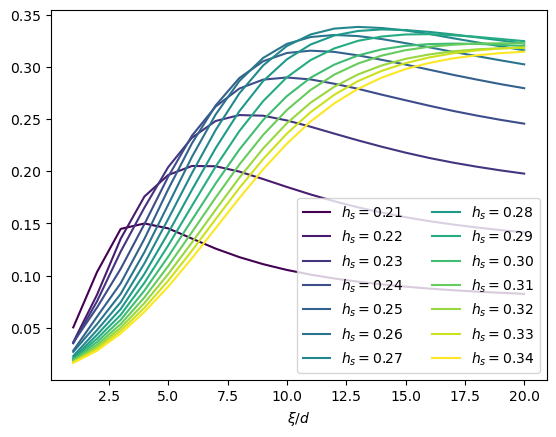

In [18]:
# Define the colormap
cmap = cm.viridis(np.linspace(0, 1, 14))

fig, ax = plt.subplots()

for i, hs in enumerate(hs_ax):
    ax.plot(xi_ax, q[:, i], "-", label=rf"$h_s={hs:3.2f}$", color=cmap[i])

ax.set_xlabel(r"$\xi/d$")
ax.legend(ncol=2)

plt.show()

Text(0, 0.5, '$\\xi/d$')

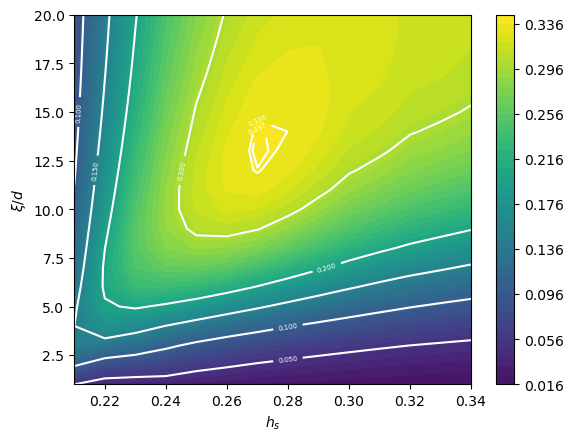

In [19]:
fig, ax = plt.subplots()


cpf = ax.contourf(hs_ax, xi_ax, q, levels=50, cmap="viridis", vmin=0)
fig.colorbar(cpf)

levels = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.336, 0.337]
cp = ax.contour(hs_ax, xi_ax, q, levels, colors="w")  # , levels=15
plt.clabel(cp, inline=1, fontsize=5)

ax.set_xlabel(r"$h_s$")
ax.set_ylabel(r"$\xi/d$")

In [20]:
maxidxs = np.unravel_index(np.argmax(q), q.shape)
h_s, xi = hs_gr[maxidxs], xi_gr[maxidxs]
print(h_s)
print(xi)

0.27
13


In [21]:
h_s = 0.270
xi = 13

In [22]:
M_up = (h_up - g * mu_B / 2 * B_ax) / h_s
M_down = (h_down - g * mu_B / 2 * B_ax) / h_s

popt_up, pcov_up = curve_fit(
    M_fun,
    B_ax[NS_idx_up:SN_idx_up],
    M_up[NS_idx_up:SN_idx_up],
    bounds=((-np.inf, 0, 0, 0, 0), (+np.inf, np.inf, np.inf, 1, 1)),
)


def M_fun_up(B):
    return M_fun(B, *popt_up)


popt_down, pcov_down = curve_fit(
    M_fun,
    B_ax[NS_idx_down:SN_idx_down],
    M_down[NS_idx_down:SN_idx_down],
    bounds=((-np.inf, 0, 0, 0, 0), (+np.inf, np.inf, np.inf, 1, 1)),
)


def M_fun_down(B):
    return M_fun(B, *popt_down)

In [23]:
h_cc = h_c * np.ones((Nx + 2 * border, Ny + 2 * border))
h_ss = h_s * np.ones((Nx + 2 * border, Ny + 2 * border))

In [24]:
nis_th_up = get_NIS(Nx, Ny, B_ax, M_fun_up, g, h_ss, h_cc, xi)
nis_th_down = get_NIS(Nx, Ny, B_ax, M_fun_down, g, h_ss, h_cc, xi)

(-1.0854476279378569, 1.0839702895378494)

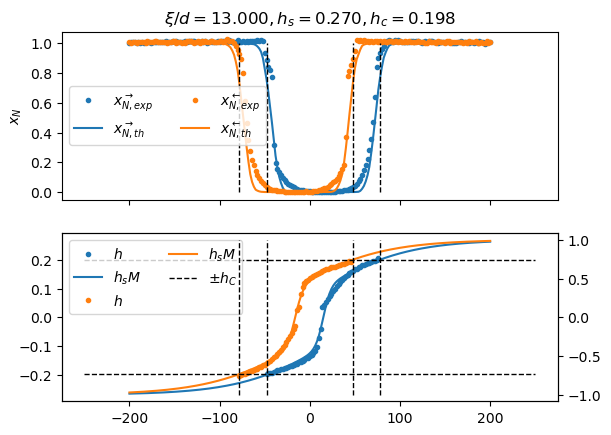

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(B_ax, x_N_up, ".C0", label=r"$x_{N, exp}^\rightarrow$")
ax1.plot(B_ax, nis_th_up, "-C0", label=r"$x_{N, th}^\rightarrow$")
ax1.plot(B_ax, x_N_down, ".C1", label=r"$x_{N, exp}^\leftarrow$")
ax1.plot(B_ax, nis_th_down, "-C1", label=r"$x_{N, th}^\leftarrow$")
ax1.legend(ncol=2)
ax1.set_ylabel(r"$x_N$")
ax1.set_title(rf"$\xi/d={{{xi:4.3f}}}, h_s = {{{h_s:4.3f}}}, h_c = {{{h_c:4.3f}}}$")
ax1.vlines(B_ax[[NS_idx_up, SN_idx_up]], 0, 1, "k", linestyles="--", linewidth=1)
ax1.vlines(
    B_ax[[NS_idx_down, SN_idx_down]], *ax2.get_ylim(), "k", linestyles="--", linewidth=1
)
# if B_star>0:
#     ax1.vlines([-B_star, B_star], 0, 1, "k", linestyles="--", linewidth=1)


ax2.plot(B_ax[NS_idx_up:SN_idx_up], h_up[NS_idx_up:SN_idx_up], ".C0", label=r"$h$")
ax2.plot(B_ax, M_fun_up(B_ax) * h_s, "-C0", label=r"$h_s M$")
ax2.plot(
    B_ax[NS_idx_down:SN_idx_down], h_down[NS_idx_down:SN_idx_down], ".C1", label=r"$h$"
)
ax2.plot(B_ax, M_fun_down(B_ax) * h_s, "-C1", label=r"$h_s M$")
ax2.hlines([-h_c, h_c], -250, 250, "k", linestyle="--", linewidth=1, label=r"$\pm h_C$")
ax2.legend(ncol=2)

ax3 = ax2.twinx()
ax3.vlines(B_ax[[NS_idx_up, SN_idx_up]], -1, 1, "k", linestyles="--", linewidth=1)
ax3.vlines(B_ax[[NS_idx_down, SN_idx_down]], -1, 1, "k", linestyles="--", linewidth=1)
ax3.set_ylim(np.array([*ax2.get_ylim()]) / h_s)

# # plt.xlim(-220, 240)  # A4 limits
# plt.xlim(-45, 75)     #12 limits

In [26]:
pdout = pd.DataFrame()

In [27]:
pdout["B_ax"] = B_ax
pdout["x_N_up"] = x_N_up
pdout["nis_th_up"] = nis_th_up
pdout["x_N_down"] = x_N_down
pdout["nis_th_down"] = nis_th_down
pdout["M_up"] = M_fun_up(B_ax)
pdout["M_down"] = M_fun_down(B_ax)

pdout.set_index("B_ax", inplace=True)
pdout.to_csv("Fig3_Sample1.csv")

# Transport

In [28]:
rho_S = 1e-9
rho_N = 1

In [29]:
W_ax = np.array([10, 20, 50, 100, 200])

for Ny in W_ax:
    print(Ny)
    Nx = 1000

    R = np.zeros(len(B_ax))
    j_x_out = np.zeros((len(B_ax), Ny, Nx))
    j_y_out = np.zeros((len(B_ax), Ny, Nx))
    deff_out = np.zeros((len(B_ax), Ny, Nx))
    mm_out = np.zeros((len(B_ax), Ny, Nx))

    x_ax = np.arange(Nx)
    y_ax = np.arange(Ny)

    dx = x_ax[1] - x_ax[0]
    dy = y_ax[1] - y_ax[0]

    xx, yy = np.meshgrid(x_ax, y_ax)

    h_cc = h_c * np.ones((Ny + 2 * border, Nx + 2 * border))
    h_ss = h_s * np.ones((Ny + 2 * border, Nx + 2 * border))

    averaging_filter = generate_averaging_filter(xi)
    mm = MicroMagnet(shape=(Ny + 2 * border, Nx + 2 * border), seed=2)

    for i, B in tqdm(enumerate(B_ax), total=len(B_ax)):
        mm.set_M(M_fun_up(B))

        h_eff = (
            oaconvolve(h_ss * mm.config, averaging_filter, mode="same")
            + g / 2 * mu_B * B
        )
        domains_sc = 1 * (abs(h_eff) < h_c)

        if border > 0:
            h_eff = h_eff[border:-border, border:-border]
            domains_sc = domains_sc[border:-border, border:-border]

        rho = np.ones((Ny, Nx)) * rho_N
        rho[domains_sc > 0.5] = rho_S

        (phi, E_x, E_y, j_x, j_y, rho, charge) = solve_circuit(
            x_ax, y_ax, rho, deltaV=1
        )

        j_x_out[i] = j_x
        j_y_out[i] = j_y
        deff_out[i] = domains_sc
        mm_out[i] = mm.config[border:-border, border:-border]

        I = np.sum(j_x, axis=0) * dy
        R[i] = 1 / np.mean(I[1:])

    with h5py.File(f"network_output/Sample1_W{Ny}.hdf5", "w") as f:
        f.create_dataset("B_ax", data=B_ax, compression="gzip")
        f.create_dataset("R", data=R, compression="gzip")
        f.create_dataset("x", data=xx, compression="gzip")
        f.create_dataset("y", data=yy, compression="gzip")
        f.create_dataset("mm", data=mm_out, compression="gzip")
        f.create_dataset("sc_zones", data=deff_out, compression="gzip")
        f.create_dataset("j_x", data=j_x_out, compression="gzip")
        f.create_dataset("j_y", data=j_y_out, compression="gzip")

10


  0%|          | 0/201 [00:00<?, ?it/s]

20


  0%|          | 0/201 [00:00<?, ?it/s]

50


  0%|          | 0/201 [00:00<?, ?it/s]

100


  0%|          | 0/201 [00:00<?, ?it/s]

200


  0%|          | 0/201 [00:00<?, ?it/s]

In [36]:
Rs = []

for Ny in W_ax:
    # Construct the file name based on the width
    file_path = f"network_output/Sample1_W{Ny}.hdf5"

    # Open the HDF5 file for reading
    with h5py.File(file_path, "r") as file:
        # Read the resistance dataset
        R = file["R"][:]
        # Append the resistance data to the list
        Rs.append(R)

# Convert the list of arrays into a 2D numpy array
Rs = np.array(Rs)

Text(0.5, 0.98, 'B = 70.0')

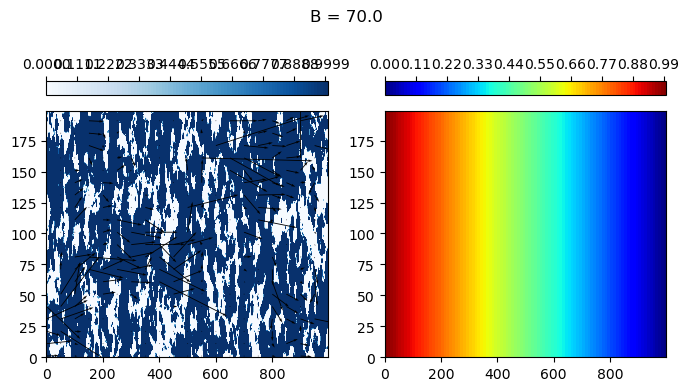

In [30]:
i = 135

j_x = j_x_out[i]
j_y = j_y_out[i]
deff = deff_out[i]

step_x = Nx // 20
step_y = Ny // 20

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
c1 = ax[0].contourf(xx, yy, deff, levels=np.linspace(0, 1.01, 101), cmap="Blues")
q1 = ax[0].quiver(
    xx[1::step_y, 1::step_x],
    yy[1::step_y, 1::step_x],
    j_x[1::step_y, 1::step_x],
    j_y[1::step_y, 1::step_x],
    color="k",
)
c2 = ax[1].contourf(xx, yy, phi, levels=101, cmap="jet")
fig.colorbar(c1, location="top")
fig.colorbar(c2, location="top")

# ax[0].axis('scaled')
# ax[1].axis('scaled')
# fig.savefig(output_dir + "/snapshot.png")

fig.suptitle(f"B = {B_ax[i]}")

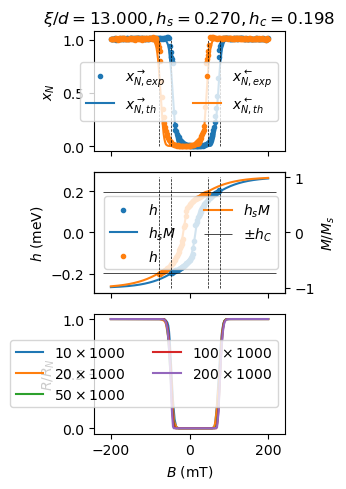

In [37]:
fig, (ax1, ax2, ax4) = plt.subplots(nrows=3, sharex=True, figsize=(3.375, 5))

ax1.plot(B_ax, x_N_up, ".C0", label=r"$x_{N, exp}^\rightarrow$")
ax1.plot(B_ax, nis_th_up, "-C0", label=r"$x_{N, th}^\rightarrow$")
ax1.plot(B_ax, x_N_down, ".C1", label=r"$x_{N, exp}^\leftarrow$")
ax1.plot(B_ax, nis_th_down, "-C1", label=r"$x_{N, th}^\leftarrow$")
ax1.vlines(B_ax[[NS_idx_up, SN_idx_up]], 0, 1, "k", linestyles="--", linewidth=0.5)
ax1.vlines(B_ax[[NS_idx_down, SN_idx_down]], 0, 1, "k", linestyles="--", linewidth=0.5)

ax1.set_ylabel(r"$x_N$")
ax1.legend(ncols=2)
ax1.set_title(rf"$\xi/d={{{xi:4.3f}}}, h_s = {{{h_s:4.3f}}}, h_c = {{{h_c:4.3f}}}$")

ax2.plot(B_ax[NS_idx_up:SN_idx_up], h_up[NS_idx_up:SN_idx_up], ".C0", label=r"$h$")
ax2.plot(B_ax, M_fun_up(B_ax) * h_s, "-C0", label=r"$h_s M$")
ax2.plot(
    B_ax[NS_idx_down:SN_idx_down], h_down[NS_idx_down:SN_idx_down], ".C1", label=r"$h$"
)
ax2.plot(B_ax, M_fun_down(B_ax) * h_s, "-C1", label=r"$h_s M$")
ax2.hlines(
    [-h_c, +h_c], *ax2.get_xlim(), "k", linestyle="-", linewidth=0.5, label=r"$\pm h_C$"
)
ax2.set_ylabel(r"$h$ (meV)")
ax2.legend(ncols=2)

ax3 = ax2.twinx()
ax3.vlines(B_ax[[NS_idx_up, SN_idx_up]], -1, 1, "k", linestyles="--", linewidth=0.5)
ax3.vlines(B_ax[[NS_idx_down, SN_idx_down]], -1, 1, "k", linestyles="--", linewidth=0.5)
ax3.set_ylim(np.array([*ax2.get_ylim()]) / h_s)
ax3.set_ylabel(r"$M/M_s$")


for j in range(len(W_ax)):
    ax4.plot(B_ax, Rs[j, :] * W_ax[j] / Nx, "-", label=rf"${W_ax[j]}\times{Nx}$")
ax4.set_ylabel(r"$R/R_N$")
ax4.legend(ncols=2)
# ax4.set_ylim(0, 1)

ax4.set_xlabel(r"$B$ (mT)")
fig.tight_layout()